# ML-8. Ансамблирование. Бэггинг, стекинг, бустинг

Для этого возьмём датасет по решению задачи на прогрессирование диабета. Мы будем предсказывать уровень прогрессирования болезни относительно базового уровня (некоторая численная мера, насколько «сильно» болен пациент диабетом). Минимальное значение составляет 25, максимальное — 346. Далее посмотрим на распределение, чтобы убедиться, что это не многоклассовая классификация, данные нормированы и закодированы категориальным кодировщиком. 

Качество будем измерять по среднему квадрату ошибки (MSE) на кросс-валидации с точностью до второго знака после запятой. 

Для чистоты эксперимента возьмём решающее дерево с глубиной 10 (DecisionTreeRegressor) и случайный лес из 10 деревьев (параметр n_estimators) с глубиной 10 (RandomForestRegression). Предлагается исполнить код:

In [1]:
# Импортируем библиотеки
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

**Загрузка данных**

In [2]:
# Загрузим датасет из библиотеки
data = load_diabetes(as_frame=True)
# Создаем матрицу наблюдений
X = data['frame'].drop('target', axis=1)
# Создаем вектор правильных ответов
y = data['target']
 
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


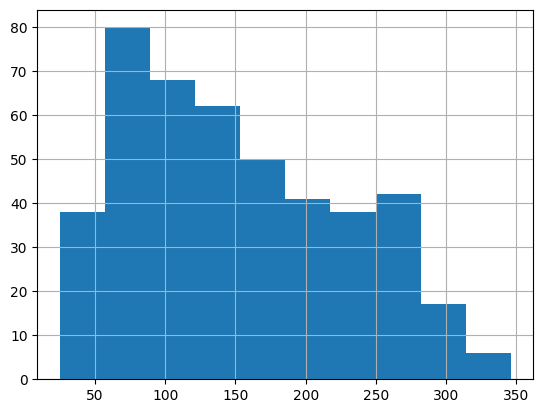

In [3]:
# Посмотрим на распределение целевого признака
y.hist();

In [5]:
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Посмотрим на размерности выборок
print(f'Размерность обучающей выборки {X_train.shape}')
print(f'Размерность тестовой выборки {X_test.shape}')

Размерность обучающей выборки (296, 10)
Размерность тестовой выборки (146, 10)


## Бэггинг: случайный лес. 


In [18]:
# Создаем модель дерева решений с максимальной глубиной 10 
regr1 = DecisionTreeRegressor(max_depth=10, random_state=42)
# Обучаем модель
regr1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [19]:
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева 
regr2 = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)
# Обучаем модель
regr2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [20]:
# Формируем предсказания каждой из моделей
y_pred1 = regr1.predict(X_test)
y_pred2 = regr2.predict(X_test)
 
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для решающего дерева {round(mean_squared_error(y_test, y_pred1),2)}')
print(f'Качество предсказания по MSE для случайного леса  {round(mean_squared_error(y_test, y_pred2),2)}')

Качество предсказания по MSE для решающего дерева 6132.51
Качество предсказания по MSE для случайного леса  3533.73


 ## Стекинг

Стекинг (stacking) — алгоритм построения ансамбля, в котором параллельно и независимо друг от друга обучаются несколько базовых моделей (необязательно одной природы), а их предсказания используются для обучения метамодели (финальная модель) как факторы.

Предсказания базовых алгоритмов называются метапризнаками. 

Простейшая реализация стекинга заключается в блендинге (blending). 

Суть блендинга состоит в следующем: предположим у нас есть обучающая выборка , которую мы делим пополам. Первая часть используется для обучения базовых моделей, а на второй базовые модели делают предсказания – метапризнаки, на которых уже и обучается в дальнейшем метамодель. 

Недостатки блендинга видны невооруженным глазом: ни базовые модели, ни метамодель не обучаются на полных данных. 

Для решения этой проблемы используется усовершенствованная модель блендинга, которая имеет полноценное название — стекинг. Идея борьбы с недостатком блендинга — использование кросс-валидации.

Рассмотрим как обучается классический стекинг. Пусть у нас есть таблица с примерами X и ответами на них y. Количество признаков — m, количество наблюдений — n, количество моделей в стекинге — K.

1. Обучающая выборка разбивается на L равных частей, называемых фолдами. 
2. Затем для каждой базовой модели эти фолды перебираются следующим образом: на каждом шаге фиксируются L-1 фолдов для обучения базовых моделей и один фолд для предсказания (в случае бинарной классификации каждая модель предсказывает вероятность принадлежности к классу 1, в случае мультиклассовой классификации — к каждому классу). В результате будет сформировано L предсказаний, из которых формируется метапризнак Mj, где j — номер модели.
Такой подход к формированию метапризнаков позволяет избежать переобучения. Действительно, можно рассматривать L-1 фолд как обучающую выборку, а оставшийся — как тестовую. Таким образом, мы обучаемся на тренировочной выборке, но предсказания делаем для той выборки, которую ещё не видели.

3. После того как мы проделаем шаг 2 для всех базовых моделей, мы получим новый набор данных, состоящий из  метапризнаков — предсказаний каждой из моделей. Предсказания моделей будут использоваться в качестве метапризнаков, на которых будет обучена метамодель.

Давайте посмотрим, как работает алгоритм на конкретной таблице. Пусть у нас есть некоторый набор данных из четырёх признаков, характеризующих клиента (x_0, x_1, x_2 и x_3), и восемь наблюдений. На основе этих признаков необходимо предсказать бинарный целевой признак (y) покупки товара со значениями 1 (купил) и 0 (не купил). Будем использовать стекинг, состоящий из трёх различных моделей.

Разбиваем выборку на четыре фолда, то есть в каждом фолде будет по две строки таблицы (обозначены цветом). Обучаем каждую модель на трёх из этих фолдов и делаем предсказание вероятности покупки для оставшегося.

Из предсказаний будет сформировано три метапризнака (по одному на каждую базовую модель). Это будут предсказанные базовыми классификаторами вероятности покупки (вероятность принадлежности к классу 1).

dst3-ml3-8_4.png --> dst3-ml3-8_5.png

Важно понимать, стекинг — это чистая эвристика, эффективность которой доказана только практическим применением. Стекинг использует тот же подход, что и нейронные сети: предсказания предыдущего этапа (слоя) используются в качестве признаков для следующего этапа (слоя).

С точки зрения смещения и разброса, стекинг не имеет прямой математической интерпретации, так как не минимизирует напрямую ни ту, ни другую компоненту ошибки. Удачно работающий стекинг просто уменьшает ошибку, но гарантий уменьшения смещения или разброса нет.

Есть некоторые рекомендации, как правильно строить стекинг:
- В качестве метамоделей лучше всего применять простые модели: например, для задачи регрессии — линейную регрессию, а для задачи классификации — логистическую регрессию.
- В качестве базовых моделей лучшего всего использовать модели различной природы.

Из всех ансамблевых методов стекинг применяется реже всего. Главная причина: так как используется много разных моделей, необходимо подбирать их внешние параметры (коэффициенты регуляризации, глубина деревьев, число деревьев, темп обучения и т. д.) в совокупности, а подбор огромного количества параметров очень затратен по времени (мы убедились в этом в модуле по подбору внешних параметров моделей).

Вторая причина — в отличие от бэггинга и бустинга, для стекинга нет каких-то готовых решений, таких как случайный лес и градиентный бустинг над деревьями. Базовые модели нужно подбирать самому, а какие из них подойдут лучше всего — открытый вопрос.
Но, несмотря на эти недостатки, при грамотном подходе опытные специалисты выигрывают соревнования на Kaggle благодаря стекингу. Хотя зачастую таких участников называют «читерами» (от англ. cheat — «жульничать, обманывать»), ведь часто они собирают чуть ли не все возможные ML-модели в стекинг, запускают на мощном сервере подбор внешних параметров и комбинации из этих моделей в стекинге получают заветные 1.5 % прироста качества модели. На Kaggle даже существует фраза — «настекали».

В реальных условиях такой прирост значит мало, поэтому мы не будем концентрироваться на стекинге в нашем курсе, но пример разберём.

Стекинг для задачи регрессии имеет реализацию в библиотеке scikit-learn в классе StackingRegressor, для задачи классификации — в классе StackingClassifier. На вход подаётся список базовых моделей (атрибут estimators) и метамодель (атрибут final_estimator).

Примечание. Стоит понимать, что для задачи регрессии все базовые модели должны быть регрессорами, а для задачи классификации — классификаторами.  

Попробуем на практике применить стекинг, используя реализацию из библиотеки sklearn. В качестве входных данных будем использовать данные про диабет, использованные ранее. Обратимся снова к коду и обучим модель на данных.

Как и все ансамбли, модель стекинга находится в модуле ensemble.

In [22]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

Основные параметры StackingRegressor:

- estimators — список из кортежей базовых моделей в виде (str, model). Первым элементом в каждом кортеже идет строка с именем модели, вторым — собственно сама модель.
- final_estimator — метамодель.
- cv — количество фолдов, на которые делится выборка. По умолчанию используется пять фолдов.

Будем строить стекинг на следующих моделях:
- 'dt' — дерево решений;
- 'lr' — ридж-регрессия, линейная модель регрессии с L2-регуляризацией;
- случайный лес с количеством деревьев, равным 10, в качестве метамодели.

Примечание. В данном случае мы рассматриваем RidgeCV, которая представляет собой ридж-регрессию со встроенной кросс-валидацией по методу Leave-One-Out Cross-Validation. Подробнее читайте по ссылке.

Создадим список кортежей в формате ("наименование модели", модель) из этих моделей, и назовем его estimators:

In [29]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

# Теперь, когда список из базовых моделей готов, создадим объект класса StackingRegressor. 
# Первым аргументом передаём список из базовых моделей. Будем использовать в качестве метамодели модель случайного леса. 
# Для этого передаём её в параметр final_estimator. Остальные параметры оставим по умолчанию.

# Обучаем модель с помощью метода fit(), делаем предсказание классов с помощью метода predict(), а затем считаем метрики:
# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
# Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [27]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack), 2)}')

Качество предсказания по MSE для стекинга 3467.74


Посмотреть на метапризнаки можно с помощью метода transform(). Для этого в метод нужно передать матрицу наблюдений X. В результате вызова метода для всех объектов каждая из двух моделей сделает предсказание вероятностей и вернёт матрицу из двух столбцов. Оформим её в виде DataFrame:

In [28]:
# Получаем мета-признаки из тренировочных данных
meta_data = reg.transform(X_train)
# Создаем DataFrame
meta_df = pd.DataFrame(
    meta_data, #содержимое таблицы
    columns=['meta_feature1', 'meta_feature2',] #название столбцов
)
meta_df.head()

,meta_feature1,meta_feature2
0,152.477333,154.0
1,202.022338,192.0
2,133.718464,116.0
3,146.698345,81.0
4,169.783292,122.0


 ## Бустинг
 



Бустинг (boosting) — это алгоритм построения ансамбля, основанный на последовательном построении слабых моделей, причём каждая новая модель пытается уменьшить ошибку предыдущей. После того как все модели обучены, они объединяются в композицию.

Примечание. Под слабыми моделями мы подразумеваем модели, точность которых немногим выше, чем случайное угадывание. Как правило, это короткие деревья решений, они обладают слабой предсказательной способностью.

Обратите внимание, что в бустинге базовые модели обучаются последовательно, а не параллельно, как в предыдущих методах, исправляя ошибки своего «предшественника»  и повышая качество всего ансамбля. 

Бустинг основан на вопросе, поднятом исследователями М. Кернсом и Л. Вэлиантом: «Может ли набор слабых обучающих алгоритмов создать сильный обучающий алгоритм?»

В отличие от бэггинга, бустинг обучается на одном и том же наборе данных, без генерации дополнительных выборок. Однако в процессе обучения меняются так называемые веса наблюдений. Если слабая модель допустила ошибку на каких-то примерах, то значимость (вес) этих примеров увеличивается и на них концентрируется следующая за ней модель.

**Так же как и бэггинг, бустинг предназначен для обучения моделей одного типа. То есть нельзя последовательно обучить 50 логистических регрессий, а затем 50 деревьев решения.**

Каждая модель создаётся для того, чтобы найти ошибки предыдущей. Сами по себе они решают задачу плохо, но стоит объединить их усилия, и мы получим супермодель.

*Примечание*. Когда все модели из ансамбля обучены и составлена композиция из них, для того, чтобы совершить предсказание на новом объекте, необходимо «прогнать» характеристики объекта через все модели в той же последовательности, в которой они обучались, и объединить их результат.

Если бэггинг создавался с целью уменьшить разброс модели, то цель бустинга — уменьшить смещение модели.

Каждый следующий базовый алгоритм в бустинге обучается так, чтобы уменьшить общую ошибку всех своих предшественников. Как следствие, итоговая композиция будет иметь меньшее смещение, чем каждый отдельный базовый алгоритм (хотя уменьшение разброса также может происходить).

В предельном случае модель может обучиться так, что не будет допускать ошибок вовсе. Однако мы знаем, что это не всегда хорошо, ведь в таком случае модель может полностью подстроиться под обучающий набор данных и переобучиться.
Поскольку основная цель бустинга — уменьшение смещения, в качестве базовых моделей часто выбирают алгоритмы с высоким смещением и небольшим разбросом, например короткие деревья решений. У каждого из таких деревьев слабая предсказательная способность, но если их объединить, мы получим очень мощную модель. 

В этом юните мы постараемся затронуть основные шаги эволюции бустинга от первой успешной модели до современных модификаций. Начнём рассмотрение с самой первой модели бустинга — адаптивного бустинга.

### Адаптивный бустинг

Первая реализация бустинга называлась AdaBoost. Это модель, которая подразумевает воплощение той самой идеи взвешивания объектов, которую мы рассмотрели выше. Алгоритм предполагает постоянную модификацию объектов выборки путём их взвешивания, причём веса обновляются специальным образом: каждая новая модель из ансамбля обучается на взвешенных данных и обращает большее внимание на ошибки своих предшественников.

Так как алгоритм является несовершенным и в дальнейшем получил свое развитие, мы не будем подробно останавливаться на его работе. Однако приведем краткое описание работы алгоритма на примере задачи бинарной классификации. 

Пусть у нас есть набор данных X, в котором N объектов размерности m (вектора в признаковом пространстве размера M) и метки класса y∈−1,1, где -1 и 1 — метки отрицательного и положительного класса соответственно.

Будем строить ансамбль из K абстрактных базовых моделей — классификаторов. Обозначим их как a(x) (это могут быть логистические регрессии/деревья решений или что-то ещё).  

В чём плюсы такого алгоритма?

✔️ Он прост. Обратите внимание: все математические операции — школьный курс математики, о высшей математике даже не идёт речи. Операции просты в реализации и не требуют вычисления производных, умножений матриц и прочих сложных математических конструкций.

✔️ Накладные расходы бустинга минимальны. Время построения определяется временем построения базовых моделей.

✔️ Показывает хорошую обобщающую способность.

✔️ Имеет возможность идентификации шумовых объектов в ряде случаев.

Но в чём минусы?

⛔️ Жадное добавление алгоритмов приводит к неоптимальности композиции.

⛔️ Склонен к переобучению при наличии шума в данных.

⛔️ Алгоритм является эвристикой, и «взвешивание» объектов, на котором он основан, не подкреплено математическим обоснованием.

В sklearn адаптивный бустинг над решающими деревьями реализован в модуле sklearn.ensemble в виде классов AdaBoostRegressor и AdaBoostClassifier для задач регрессии и классификации соответственно. Давайте проведём обучение на тех же данных, что и в предыдущих моделях ансамблирования — на данных о диабете. 

Прежде чем перейти к практической части, предлагаем ознакомиться с параметрами AdaBoost:
- estimator — параметр отвечает за природу базовых моделей, по умолчанию это DecisionTreeRegressor c максимальной глубиной (max_depth) 3.
- n_estimators — максимальное количество базовых моделей, по умолчанию равно 50. В случае идеального обучения алгоритм завершается ранее, чем данное значение.
- learning_rate — темп обучения, параметр, добавляющий дополнительный множитель весу базовой модели, по умолчанию он равен 1.
- loss{'linear', 'square', 'exponential'} — функция ошибки для обновления весов (в теоретической части мы рассматривали экспоненциальную форму обновления весов — 'exponential')
- random_state — параметр, фиксирующий случайные процессы в модели.

Для сравнимости результатов со случайным лесом возьмём количество базовых моделей, равное 10. Как говорилось ранее, глубина деревьев должна быть меньше, чем у случайного леса. По умолчанию она равна 3.  

In [43]:
from sklearn.ensemble import AdaBoostRegressor

# Создаем объект класса дерева решений
dt = DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt, #базовая модель
    n_estimators=10, #количество моделей в ансамбле
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
ada.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
ada_pred  = ada.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')


Качество предсказания по MSE для AdaBoost 3040.83


### Градиентный бустинг (регрессия)

Градиентный бустинг (Gradient Boosting, GB) — это наиболее обобщённая версия бустинга, закреплённая математическим обоснованием. Впервые алгоритм был опубликован профессором статистики Стэнфордского университета Джеромом Фридманом. Алгоритм оказался очень эффективным и в дальнейшем был множество раз модифицирован — до Extreme Gradient Boosting (XgBoost) и других модификаций, таких как CatBoost от Яндекса и LightGMB от Microsoft.

Сейчас градиентный бустинг и его модификации применяются практически везде. Любой запрос на Яндексе, выбор отеля на Booking или сериала на Netflix — всё это работает на градиентном бустинге. 

→ В этом модуле мы кратко рассмотрим принцип работы, а в модулях по математике разберём математическую формализацию алгоритма. 

В GB принцип классического бустинга сохраняется: каждый последующий алгоритм улучшает предыдущий, но, в отличие эвристического «взвешивания» наблюдений, градиентный бустинг использует информацию о функции потерь для построения нового алгоритма. 

Бустинг, использующий в качестве базовой модели дерево решений, называется градиентным бустингом над деревьями решений (Gradient Boosting on Decision Trees, GBDT). 

Основным преимуществом такой схемы градиентного бустинга является эффективность в поиске нелинейных зависимостей в сравнении с любыми моделями, основанными на решающих деревьях. Это преимущество стало причиной доминирования GBDT на огромном спектре соревнований — от кредитного скоринга до рекомендательных систем.

В заключение введения в градиентный бустинг приведём некоторые рекомендации по выбору внешних параметров алгоритма:
- Количество деревьев (n_estimators). Чем больше деревьев вы берёте, тем меньше ошибка на обучающем наборе данных, вплоть до 0, но, как вы понимаете, тем выше шанс переобучиться. Лучше начинать с небольшого количества моделей (50-100), а затем следить за ошибкой на тестовой выборке.
- Темп обучения  (learning_rate). Чем выше темп обучения, тем больше вклад каждого следующего дерева будет в модель и тем быстрее вы сойдётесь к минимуму функции потерь и сведёте ошибку к 0. Однако снова высок риск переобучения. Рекомендуемые значения — от 0.01 до 1.
- Максимальная глубина деревьев (max_depth). Градиентный бустинг лучше всего работает со слабыми моделями — это короткие деревья решений с глубиной от 1 до 8.

→ Все параметры влияют на обучение комплексно, поэтому их следует подбирать одновременно. О том, какие инструменты для этого существуют, мы поговорим в отдельном модуле.

Чтобы понять, как на градиентный бустинг влияют параметры темпа обучения, максимальной глубины деревьев и количества деревьев, предлагаем вам поиграть с настройками градиентного бустинга интерактивной демонстрации Brilliantly wrong.

Вы можете регулировать следующие параметры:
- tree depth — максимальная глубина деревьев;
- learning rate — темп обучения;
- subsample — процент выборки, отведённый на обучение;
- trees — количество деревьев.

На демонстрации вы сможете увидеть, как меняется функция ошибки на тренировочной (train loss) и тестовой (test loss) выборках при изменении параметров, а также как меняется вид разделяющей поверхности.

Как и все ансамбли, градиентный бустинг находится в модуле ensemble библиотеки sklearn. В качестве входных данных продолжим использовать данные о диабете.

 Градиентный бустинг над деревьями для решения задачи регрессии реализован в классе GradientBoostingRegressor. Для задачи классификации данный метод реализован в классе GradientBoostingClassifier. Параметры у классов схожи, различия только в функции потерь. Поэтому мы можем рассмотреть параметры GradientBoostingRegressor, подразумевая, что у классификатора они идентичны.

Основные параметры GradientBoostingRegressor:
- loss — функция потерь. По умолчанию в регрессии 'squared_loss' - наша любимая MSE, а в классификации 'log_loss' - логистическая функция потерь.
- learning_rate — темп обучения. По умолчанию 0.1. 
- n_estimators — количество деревьев в бустинге (число K из бустинга). По умолчанию равно 100.
- max_depth — максимальная глубина одного дерева. По умолчанию равна 3 — строятся короткие деревья с большим смещением.
- min_samples_leaf — минимальное число объектов в листе. По умолчанию 1.
- random_state — число, отвечающее за генерацию случайных чисел.

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=3, #максимальная глубина дерева
    n_estimators=10, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для GradientBoostingRegressor {round(mean_squared_error(y_test, gb_pred),2)}')

Качество предсказания по MSE для GradientBoostingRegressor 3477.3


Из полученных в предыдущем задании результатов видно, что повысить качество ансамбля моделей можно, увеличив количество моделей в ансамбле. Однако важно понимать, что зависимость качества ансамбля от количества моделей является нелинейной. При большом количестве моделей градиентный бустинг может уходить в переобучение, тем самым ухудшая метрики на тестовой выборке.

Основной фактор, влияющий на зависимость качества ансамбля от количества моделей в нем — сложность исходных данных.

### Градиентный бустинг (классификация)

✍️ Попробуем решить задачу бинарной классификации с помощью градиентного бустинга. Для этого возьмём датасет качества вина. В качестве целевой метки будем считать качественным вино, рейтинг которого больше пяти.

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [50]:
# Читаем исходные данные к задаче классификации
df = pd.read_csv('data/winequality-red.csv', sep = ';')
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [51]:
# Создаем матрицу наблюдений 
X = df.drop(['quality'],axis = 1)
# Создаем вектор признаков для бинарной классификации
y = (df['quality'] >5).astype(int)

In [52]:
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
# Посмотрим на размерности выборок
print(f' Размерность обучающей выборки {X_train.shape}')
print(f' Размерность тестовой выборки {X_test.shape}')

 Размерность обучающей выборки (1071, 11)
 Размерность тестовой выборки (528, 11)


In [54]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.1, #темп обучения
    n_estimators=100, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       238
           1       0.81      0.80      0.81       290

    accuracy                           0.79       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.79      0.79      0.79       528



In [55]:
# Прогнозируем вероятности принадлежности к классам
y_pred_proba = gb.predict_proba(X_test)
print(y_pred_proba)

[[0.7575177  0.2424823 ]
 [0.81931477 0.18068523]
 [0.80325657 0.19674343]
 ...
 [0.0212709  0.9787291 ]
 [0.90355559 0.09644441]
 [0.80946194 0.19053806]]


Известно, что с уменьшением темпа обучения (learning_rate) возникает необходимость повышения количества базовых моделей, то есть существует некоторая дилемма (trade-off) между темпом обучения и количеством моделей (n_estimators). Посмотрим на практике, как эти параметры связаны между собой. 

In [58]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.2, #темп обучения
    n_estimators=500, #число деревьев
    max_depth=3, #максимальная глубина дерева
    min_samples_leaf=10,
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       238
           1       0.81      0.83      0.82       290

    accuracy                           0.80       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.80      0.80      0.80       528



⭐️ Поздравляем! Мы разобрали практически все ныне существующие методы ансамблирования — от самых простых, которые легли в основу случайного леса, до самых передовых (градиентных бустингов). Мы посмотрели на реализации в библиотеке sklearn, постарались разобрать методологию и основные параметры каждой модели. 

Основными рекомендациями по использованию ансамблей является использование случайных лесов и градиентных бустингов в первую очередь для классических задач классификации и регрессии с простыми табличными данными, так как подавляющее большинство соревнований в этой области было выиграно именно благодаря этим двум моделям. 

После данного модуля может сложиться впечатление, что ансамблирование — всегда лучший вариант для финальной модели, однако часто в задачах требуется интерпретируемость результатов, которой не могу похвастаться бустинг и стекинг. 

Кроме того, использование случайного леса на данных с большим количеством выбросов может привести к тому, что модель будет обучается на данных, у которых дисперсия в разы больше, чем у исходных, так как подвыборка для обучения выбирается случайно. Таким образом, мы не сможем получить выигрыш в дисперсии, который нам даёт ансамблирование. 

В заключение приведём таблицу преимуществ и недостатков методов ансамблирования:


**Бэггинг**\
✔️ Плюсы
- Хорошо параллелится вычисление (модели обучаются параллельно)
- Снижает дисперсию

⛔ Минусы
- Предполагается использование одинаковых моделей
- Необходимо использование глубоких деревьев
- Плохо интерпретируемая

**Стекинг**\
✔️ Плюсы
- Хорошо параллелится (модели обучаются параллельно)
- Хорош для использования различных по природе базовых моделей

⛔ Минусы
- Качество сильно зависит от качества базовых моделей
- Плохо интерпретируемая

**Бустинг**\
✔️ Плюсы
- Модели обучаются последовательно, уточняя друг друга
- Снижает смещение
- Базовые модели — неглубокие деревья

⛔ Минусы
- Плохо параллелится вычисление
- Плохо интерпретируемая
